In [1]:
!pip install apache-tvm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from skimage import io, color
import matplotlib.pyplot as plt
import numpy as np

import tvm
from tvm import relay
from tvm.contrib import graph_executor

In [3]:
lenna_url = "http://www.lenna.org/lena_std.tif"

In [4]:
def read_image(url):
  image = io.imread(url)
  return image

def display_image(data):
  plt.figure()
  if len(data.shape) == 3:
    plt.imshow(data)
  else:
    assert(len(data.shape) == 2)
    plt.imshow(data[:, :], cmap=plt.cm.gray)
  
def rgb2gray(data):
  gray = color.rgb2gray(data)
  return gray

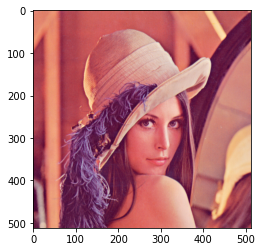

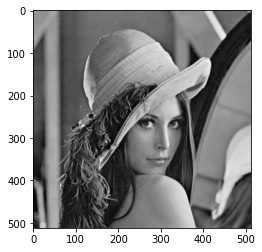

In [5]:
rgb_img = read_image(lenna_url)
display_image(rgb_img)

data = gray_img = rgb2gray(rgb_img)
display_image(data)

In [6]:
def get_filter(dtype="float32"):
  sobelv = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=dtype)
  sobelh = sobelv.transpose()
  sobel = np.array((sobelh, sobelv))
  sobel = np.expand_dims(sobel, axis=3)
  sobel = sobel.transpose(1, 2, 3, 0)
  return sobel

def get_model(input_shape, dtype="float32"):                          
  filter = get_filter(dtype)
  input = tvm.relay.var("input", shape=input_shape, dtype=dtype)
  weight = tvm.relay.var("weight", shape=filter.shape, dtype=dtype)
  D = relay.nn.conv2d(input, weight, padding=(1, 1), data_layout="NHWC", kernel_layout="HWIO", out_dtype=dtype)
                                                                          
  mod = relay.Function([input, weight], D)
  params = {       
      "weight": tvm.nd.array(filter)                                     
  }         
  return mod, params

In [7]:
def expand_image_dims(data):
    assert(len(data.shape) == 2)
    return np.expand_dims(data, axis=(0, 3))

data = expand_image_dims(data)
mod, params = get_model(data.shape)
print(mod)

fn (%input: Tensor[(1, 512, 512, 1), float32], %weight: Tensor[(3, 3, 1, 2), float32]) {
  nn.conv2d(%input, %weight, padding=[1, 1, 1, 1], data_layout="NHWC", kernel_layout="HWIO", out_dtype="float32")
}


In [8]:
def infer_model(data, mod, params, target="llvm"):                          
    with tvm.transform.PassContext(opt_level=3):           
        lib = relay.build(mod, target=target, params=params)
    dev = tvm.device(target, 0)
    gmod = graph_executor.GraphModule(lib["default"](dev))
    gmod.set_input(**params)
    gmod.set_input("input", data)
    num_iter = 10
    time_f = gmod.module.time_evaluator("run", dev, number=num_iter)
    cost = time_f().mean 
    print("%g ms\n" % (cost * 1000))                           
    tvm_output = gmod.get_output(0)                                
    output = tvm_output.asnumpy()
    return output

1.52644 ms



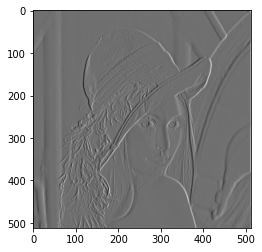

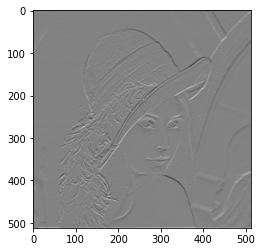

In [9]:
target = "llvm -mcpu=core-avx2"
out = infer_model(data, mod, params, target)
display_image(out[0, :, :, 0])
display_image(out[0, :, :, 1])

In [10]:
def grad_amplitude(dx, dy):
  return np.sqrt(dx ** 2 + dy ** 2)

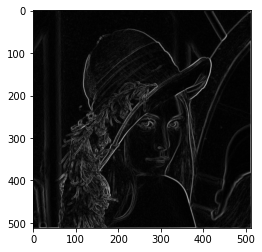

In [11]:
union = grad_amplitude(out[0, :, :, 0], out[0, :, :, 1])
display_image(union)

# Tuning with AutoTVM

In [12]:
def evaluate_performance(lib, data_shape, dtype="float32"):
    # upload parameters to device
    dev = tvm.cpu()
    data_tvm = tvm.nd.array((np.random.uniform(size=data_shape)).astype(dtype))
    module = graph_executor.GraphModule(lib["default"](dev))
    module.set_input(input_name, data_tvm)

    # evaluate
    print("Evaluate inference time cost...")
    print(module.benchmark(dev, number=100, repeat=3))

# extract workloads from relay program
def extract_tasks(mod, target, params):
    print("Extract tasks...")
    print(mod)
    tasks = autotvm.task.extract_from_program(
        mod, target=target, params=params
    )
    assert(len(tasks) > 0)
    return tasks

def evaluate(module, data_shape, log_file, target="llvm"):
    # compile kernels in default mode
    print("Evaluation of the network compiled in 'default' mode without auto tune:")
    with tvm.transform.PassContext():
        print("Compile...")
        lib = relay.build(module, target=target, params=params)
        evaluate_performance(lib, data_shape)

    # compile kernels in kernel tuned only mode
    print("\nEvaluation of the network been tuned on kernel level:")
    with autotvm.apply_history_best(log_file):
        print("Compile...")
        with tvm.transform.PassContext():
            lib = relay.build(module, target=target, params=params)
        evaluate_performance(lib, data_shape)

In [13]:
import os
import multiprocessing

from tvm import autotvm

from tvm.autotvm.tuner import XGBTuner, GATuner, RandomTuner, GridSearchTuner

In [14]:
model_name = "my_sobel"

log_file = "%s.log" % model_name

input_name = "input"
target = tvm.target.Target("llvm -mcpu=core-avx2")

# Set number of threads used for tuning based on the number of
# physical CPU cores on your machine.
num_threads = multiprocessing.cpu_count()
print("Num threads: ", num_threads)
os.environ["TVM_NUM_THREADS"] = str(num_threads)

Num threads:  2


In [15]:
tuning_option = {
    "log_filename": log_file,
    "tuner": "xgb",
    "early_stopping": None,
    "measure_option": autotvm.measure_option(
        builder=autotvm.LocalBuilder(),
        runner=autotvm.LocalRunner(
            number=1, repeat=10, min_repeat_ms=0, enable_cpu_cache_flush=True
        ),
    ),
}

In [16]:
def run_tuning(
    tasks, measure_option, tuner="gridsearch", early_stopping=None, log_filename="tuning.log"
):
    for i, task in enumerate(tasks):
        prefix = "[Task %2d/%2d] " % (i + 1, len(tasks))

        # create tuner
        if tuner == "xgb" or tuner == "xgb-rank":
            tuner_obj = XGBTuner(task, loss_type="rank")
        elif tuner == "ga":
            tuner_obj = GATuner(task, pop_size=50)
        elif tuner == "random":
            tuner_obj = RandomTuner(task)
        elif tuner == "gridsearch":
            tuner_obj = GridSearchTuner(task)
        else:
            raise ValueError("Invalid tuner: " + tuner)

        # do tuning
        n_trial = len(task.config_space)
        tuner_obj.tune(
            n_trial=n_trial,
            early_stopping=early_stopping,
            measure_option=measure_option,
            callbacks=[
                autotvm.callback.progress_bar(n_trial, prefix=prefix),
                autotvm.callback.log_to_file(log_filename),
            ],
        )

#Optimize conv2d strategy for NHWC layout


In [17]:
dev = tvm.cpu(0)
dtype="float32"
data = expand_image_dims(gray_img)
filter = get_filter(dtype)
input_shape = data.shape
filter_shape = filter.shape

In [18]:
from tvm import te, topi
@autotvm.template("tvm_conv")
def tvm_conv():
  A = te.placeholder(input_shape, name="input", dtype=dtype)
  B = te.placeholder(filter_shape, name="filter", dtype=dtype)
  rh = te.reduce_axis((0, 3), name="rh")
  rw = te.reduce_axis((0, 3), name="rw")
  rc = te.reduce_axis((0, 1), name="rc")
  padded = topi.nn.pad(A, [0, 1, 1, 0])
  # conv = topi.nn.conv2d_nhwc(A, B, stride=[1, 1], padding=[0, 1, 1, 0], 
  #                            dilation=[1, 1], out_dtype=dtype)
  conv = te.compute((1, 512, 512, 2),
      lambda n, h, w, co: te.sum((
              padded[n, h * 1 + rh * 1, w * 1 + rw * 1, rc,].astype(dtype) 
              * B[rh, rw, rc, co].astype(dtype)
          ), axis=[rh, rw, rc],
      ),name="conv2d_nhwc",
  )
  s = te.create_schedule(conv.op)
  cfg = autotvm.get_config()
  (n, h, w, co,) = conv.op.axis
  (rh, rw, rc,) = s[conv].op.reduce_axis
  cfg.define_reorder("reorder", [n, h, w, co], policy="all")
  cfg.define_annotate("ann_try_unroll", [rh, rw, rc], policy="try_unroll")
  return s, [A, B, conv]

In [ ]:
s, (A, B, conv) = tvm_conv()
print(tvm.lower(s, [A, B, conv], simple_mode=True))

In [20]:
task = autotvm.task.create("tvm_conv", args=(), target=target)
print(task.config_space)
tasks = [task]

ConfigSpace (len=192, space_map=
   0 reorder: Reorder(policy=all) len=24
   1 ann_reduce: Annotate(policy=try_unroll) len=8
)


In [21]:
run_tuning(tasks, **tuning_option)

[Task  1/ 1]  Current/Best:   14.04/  21.24 GFLOPS | Progress: (192/192) | 82.29 s Done.


In [39]:
def run(func):
  data_tvm = tvm.nd.array((np.random.uniform(size=(1,512,512,2))).astype("float32"))
  d, w, r = tvm.nd.array(data.astype("float32")), tvm.nd.array(filter), data_tvm
  func(d, w, r)
  time_f = func.time_evaluator(func.entry_name, dev, number=100)
  cost = time_f(d, w,  r).mean
  print("%g ms\n" % (cost * 1000)) 
  out = r.numpy()
  union = grad_amplitude(out[0, :, :, 0], out[0, :, :, 1])
  display_image(union)

0.479648 ms

0.448711 ms



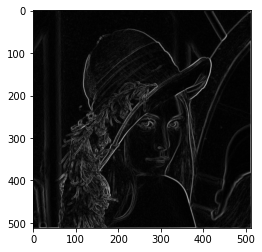

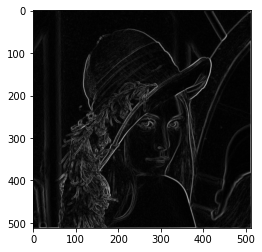

In [40]:
func = tvm.build(s, [A, B, conv], target=target, name="conv")
run(func)

with autotvm.apply_history_best('my_sobel.log'):
  func = tvm.build(s, [A, B, conv], target=target, name="conv")
  run(func)